In [1]:
from platform import python_version
python_version()

'3.6.3'

In [2]:
import bnlearn as bn
from utils import *
import matplotlib.pyplot as plt
import pickle
import classifiers
import torch
from sklearn.metrics import zero_one_loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
%matplotlib inline

In [3]:
exp_name = 'scene'#'image'

In [4]:
#Uncomment this to retrain bayesian network
# bayesian_network = bn.structure_learning.fit(error_df)

In [5]:
# f = open("scene_bn_all_errors.pkl","wb")
# pickle.dump(bayesian_network,f)
# f.close()
    
with open('scene_bn_all_errors.pkl', 'rb') as handle:
    bayesian_network = pickle.load(handle)

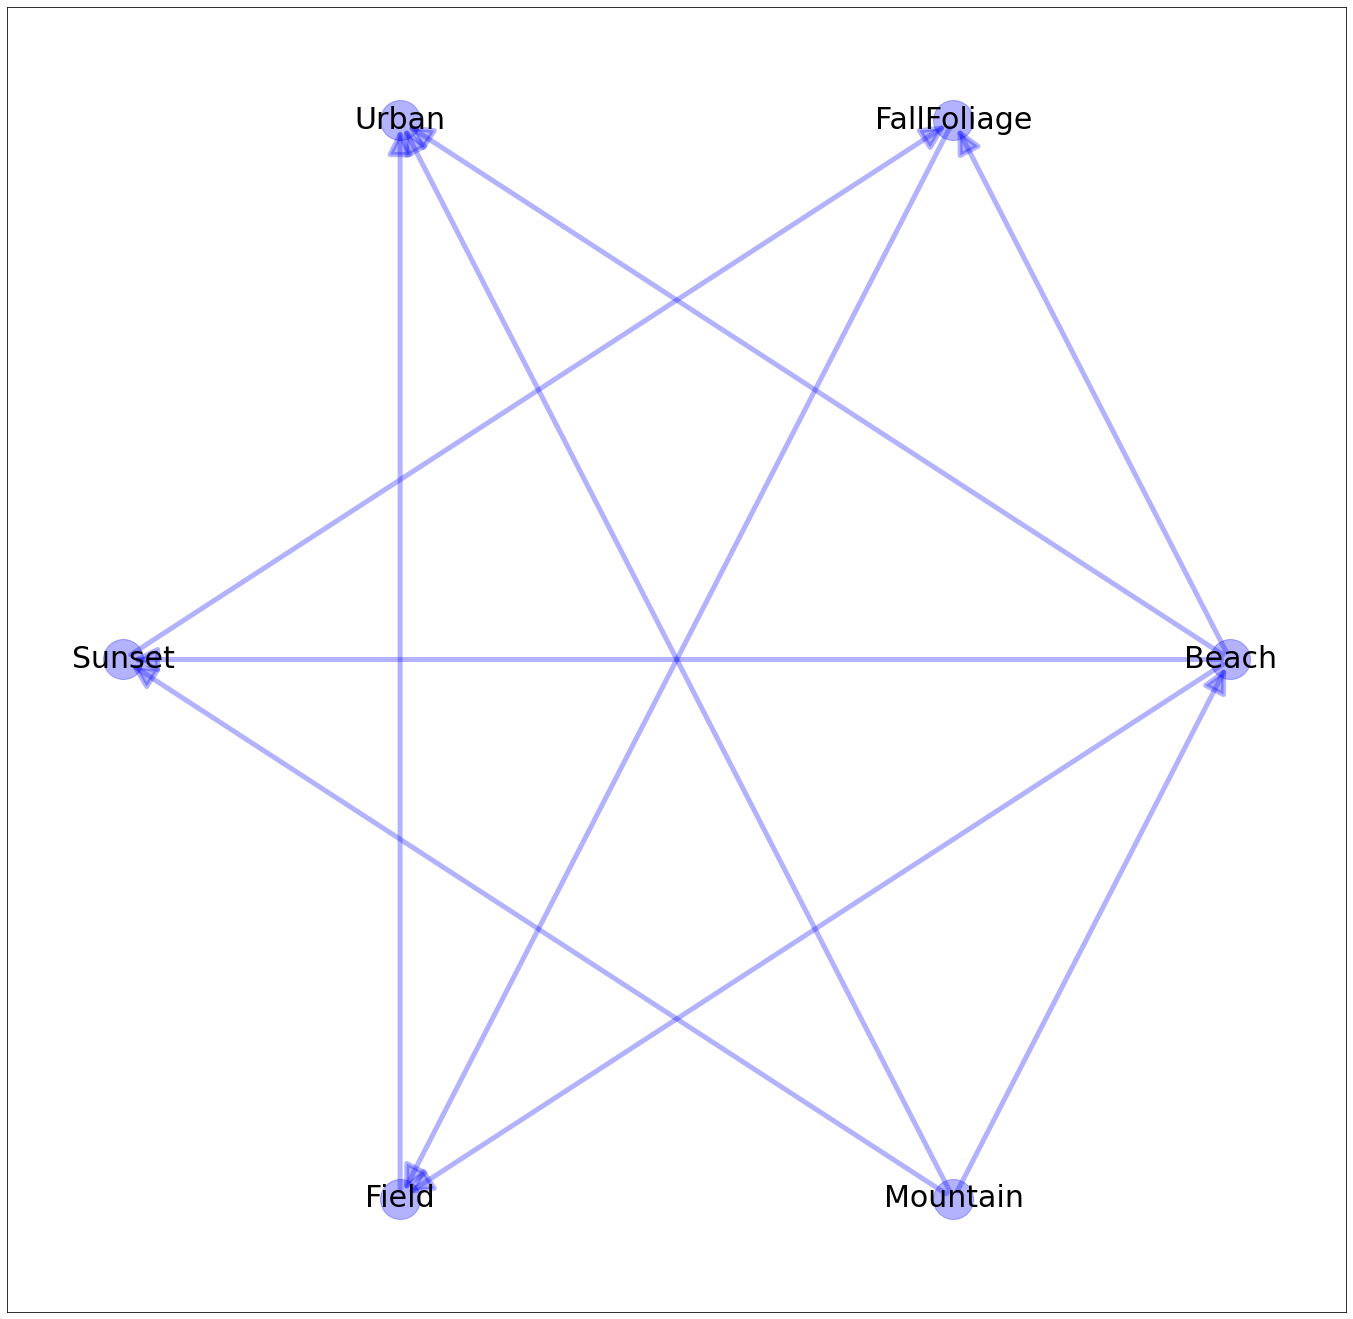

In [6]:
plt.figure(3,figsize=(24,24)) 
draw_graph(bayesian_network['model_edges'], node_text_size=30, edge_tickness=5, graph_layout='circular')


In [7]:
classes = ['Beach','Sunset','FallFoliage','Field','Mountain','Urban']

input_features = ['Att' + str(i) for i in range(1,295)]

train_data, train_labels = load_scene(partition='Train')
train_labels = make_binary(train_labels, classes)

train_df = train_data[input_features]
train_labels = train_labels[classes]
train_labels = make_binary(train_labels, classes)


# --- Device configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Hyper-parameters ---
input_size = len(input_features)
hidden_size = 100
n_hidden = 1
num_classes = len(classes)
batch_size = 128
num_epochs = 100
num_runs = 5
learning_rate = 1e-3
parent_dict = get_parent_dict(bayesian_network['adjmat'], classes)

In [ ]:
bay_clf_chain_clf_dict = {}

for run in range(num_runs):

    bay_clf_chain_clf_dict[run] = {}

        
    print('run')
    print(run)

    train_data, train_labels = load_scene(partition='Train')
    train_labels = make_binary(train_labels, classes)

    X_train = train_data[input_features].values
    y_train = train_labels[classes].values

    X_train = X_train[y_train.sum(axis=1) != 0]
    y_train = y_train[y_train.sum(axis=1) != 0]


    test_data, test_labels = load_scene(partition='Test')
    test_labels = make_binary(test_labels, classes)

    X_test = test_data[input_features].values
    y_test = test_labels[classes].values

    X_test = X_test[y_test.sum(axis=1) != 0]
    y_test = y_test[y_test.sum(axis=1) != 0]

    clf = classifiers.BayClassifierChainClf(input_size, hidden_size, num_classes, batch_size, parent_dict, classes, device, learning_rate, num_epochs, verbose=True)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    pred_proba = clf.predict_proba(X_test)
    print('0-1 Accuracy')
    print(1. - zero_one_loss(y_test, preds))
    bay_clf_chain_clf_dict[run]['01_loss'] = zero_one_loss(y_test, preds)
    bay_clf_chain_clf_dict[run]['y_test'] = y_test
    bay_clf_chain_clf_dict[run]['y_pred'] = preds
    bay_clf_chain_clf_dict[run]['y_pred_proba'] = pred_proba
        
        
        

# f = open(exp_name + "_brcc_results" + ".pkl","wb")
# pickle.dump(bay_clf_chain_clf_dict,f)
# f.close()


In [8]:
with open(exp_name + "_brcc_results" + ".pkl", 'rb') as handle:
    bay_clf_chain_clf_dict = pickle.load(handle)

In [9]:
sub_accuracy = []
macro_f1 = []
micro_f1 = []
ham_loss = []   

for run in bay_clf_chain_clf_dict.keys():
    y_test = bay_clf_chain_clf_dict[run]['y_test']
    y_pred = bay_clf_chain_clf_dict[run]['y_pred']
 
    sub_accuracy.append(1-bay_clf_chain_clf_dict[run]['01_loss'])
    macro_f1.append(f1_score(y_test, y_pred, average='macro'))
    micro_f1.append(f1_score(y_test, y_pred, average='micro'))
    ham_loss.append(hamming_loss(y_test, y_pred))


In [10]:
print('SA Mean: {}, SA CI: {}'.format(confidence_interval(sub_accuracy)[0], confidence_interval(sub_accuracy)[1])) 
print('Micro F1 Mean: {}, Micro F1 CI: {}'.format(confidence_interval(micro_f1)[0], confidence_interval(micro_f1)[1])) 
print('Macro F1 Mean: {}, Macro F1 CI: {}'.format(confidence_interval(macro_f1)[0], confidence_interval(macro_f1)[1])) 
print('Hamming Loss Mean: {}, Hamming Loss CI: {}'.format(confidence_interval(ham_loss)[0], 
                                                          confidence_interval(ham_loss)[1])) 


SA Mean: 0.6528428093645484, SA CI: 0.006823619203928998
Micro F1 Mean: 0.7218366730192296, Micro F1 CI: 0.005051730333885783
Macro F1 Mean: 0.7269089912693459, Macro F1 CI: 0.004179687190866141
Hamming Loss Mean: 0.09740802675585285, Hamming Loss CI: 0.0015999437578406634
